## Access Maps for Paraguay

- Origins: Population grid (Worldpop downsampled to 1km)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

### Load origins and graph

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

In [2]:
# This is a Jupyter Notebook extension which reloads all of the modules whenever you run the code
# This is optional but good if you are modifying and testing source code
%load_ext autoreload
%autoreload 2

In [3]:
# paths to data (copied form DataPreparation script)
iso3 = "PRY"
epsg = 32721
base_out = "/home/wb514197/data/INFRA_SAP"
#base_out = "/home/public/Data/PROJECTS/INFRA_SAP" #r"J:\Data\PROJECTS\INFRA_SAP" GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
#define output data
focal_admin2 = os.path.join(out_folder, "admin.shp")
focal_osm = os.path.join(out_folder, "paraguay-latest.osm.pbf")
wp_1km = os.path.join(out_folder, "WP_2020_1km.tif")
urban_extents = os.path.join(out_folder, "urban_extents.shp")
airports = os.path.join(out_folder, "airports.shp")
ports = os.path.join(out_folder, "ports.shp")
borders = os.path.join(out_folder, "borders.shp")

TODO: Write code to turn **WP_2020_1km.tif** into a point shapefile, for now doing it in ARC :(

In [8]:
pop_file = os.path.join(out_folder, "WP_2020_1km.shp")
G_path = '/home/public/Data/PROJECTS/LAC_GOSTNets/graphs/PRY/G_PRY.pickle'
# global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'

In [9]:
%%time
origins = gpd.read_file(pop_file)

CPU times: user 9.59 s, sys: 304 ms, total: 9.9 s
Wall time: 9.9 s


### Prepare Graph

In [10]:
G = nx.read_gpickle(G_path)

In [11]:
for u, v, data in G.edges(data = True):
    if type(data['Wkt']) == list:
        data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

In [13]:
gn.example_edge(G)

(20, 27155, {'Wkt': 'LINESTRING (-58.9642359 -26.7886577, -58.9640267 -26.7855473, -58.9640437 -26.7853092, -58.9667331 -26.7773011, -58.968865 -26.7709322, -58.9721285 -26.7614295, -58.9767858 -26.7477964, -58.977327 -26.7461269, -58.9777862 -26.7454093, -58.9804101 -26.7425243, -58.9850959 -26.737514, -58.9876421 -26.7347914, -58.9958253 -26.7258862, -59.0029098 -26.7182108, -59.0082559 -26.7125564, -59.0116748 -26.708836)', 'id': 5253, 'infra_type': 'tertiary', 'osm_id': '117752729', 'key': 'edge_5253', 'length': 10.273043637188849, 'Type': 'legitimate'})


In [15]:
all_attr = list(G[20][27155][0].keys())
all_attr

['Wkt', 'id', 'infra_type', 'osm_id', 'key', 'length', 'Type']

In [16]:
attr_list = ['id', 'infra_type', 'osm_id', 'key', 'Type']
attr_list

['id', 'infra_type', 'osm_id', 'key', 'Type']

#### Salt Network

In [18]:
%%time
G_salt = gn.salt_long_lines(G, source='EPSG:4326', target='EPSG:32721', thresh=5000, factor=1000, attr_list=attr_list)

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When m

Identified 2604 unique edge(s) longer than 5000. 
Beginning new node creation...
24840 new edges added and 5208 removed to bring total edges to 47619
9816 new nodes added to bring total nodes to 19117
CPU times: user 9min 20s, sys: 20.7 s, total: 9min 40s
Wall time: 9min 40s


In [19]:
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)

In [23]:
gn.save(G_time, "G_PRY_Salt", os.path.join(out_folder, 'graph'))

#### Select largest graph (again)

In [24]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]

In [25]:
G_largest = list_of_subgraphs[0]

### Prepare destinations

In [27]:
inCities = gpd.read_file(urban_extents)
# inCities = gpd.read_file(cities).set_index("ID").set_geometry(inCities.representative_point())

In [28]:
inCities.head()

,ID,Pop,geometry
0,0,7366.297852,"POLYGON ((-56.52958 -22.09958, -56.51292 -22.0..."
1,2,6080.110352,"POLYGON ((-60.04625 -22.34125, -60.01292 -22.3..."
2,3,89930.921875,"POLYGON ((-55.75458 -22.47458, -55.73792 -22.4..."
3,5,8367.864258,"POLYGON ((-56.54625 -22.94958, -56.52125 -22.9..."
4,7,8470.033203,"POLYGON ((-55.54625 -23.24958, -55.51292 -23.2..."


In [29]:
pop_thresh=50000
inCities = inCities.loc[inCities.Pop>pop_thresh]
inCities['geometry'] = inCities.geometry.centroid
dest_cities = inCities.assign(dest_type = 'city')

In [30]:
len(dest_cities)

8

In [ ]:
dest_airports = gpd.read_file(airports)

In [151]:
searchfor = ['Internacional', 'International', 'internacional', 'international' , 'Guarani', 'Silvio']

['Internacional',
 'International',
 'internacional',
 'international',
 'Guarani',
 'Silvio']

In [71]:
dest_airports[dest_airports.Name.str.contains('|'.join(searchfor)).fillna(False)]

,OSM_ID,x,y,TYPE,Name,NameEN,TYPE2,geometry
47,161854062,-60.620794,-22.047334,None,Dr. Luis Maria Argaña International Airport,None,None,POINT (-60.62079 -22.04733)
62,168157706,-55.830026,-22.640971,None,Aeropuerto Internacional Dr. Augusto Roberto F...,Dr. Augusto Roberto Fuster International Airport,None,POINT (-55.83003 -22.64097)


See issue with this: https://github.com/worldbank/INFRA_SAP/issues/9

In [79]:
airports_turbo = os.path.join(out_folder, 'airports_turbo.geojson')
dest_airports = gpd.read_file(airports_turbo)

In [80]:
dest_airports['geometry'] = dest_airports.geometry.centroid
dest_airports = dest_airports.assign(dest_type = 'airport')
len(dest_airports)

2

In [104]:
dest_ports = gpd.read_file(ports).assign(dest_type = 'port')
dest_borders = gpd.read_file(borders).assign(dest_type = 'border')
dest_borders['geometry'] = dest_borders.geometry.apply(lambda x: x[0])

In [105]:
dest_all = pd.concat([dest_cities, dest_ports, dest_airports, dest_borders], ignore_index=True)

In [106]:
dest_all.dest_type.value_counts()

port       55
border     24
city        8
airport     2
Name: dest_type, dtype: int64

In [107]:
dest_all.columns

Index(['ID', 'Pop', 'geometry', 'dest_type', 'OSM_ID', 'x', 'y', 'id', '@id',
       'addr:city', 'addr:postcode', 'addr:street', 'aeroway', 'ele', 'iata',
       'icao', 'internet_access', 'name', 'name:en', 'operator', 'type',
       'wikidata', 'wikipedia', 'int_name', 'is_in:city', 'is_in:country',
       'is_in:state', 'CNTRY_NAME', 'NAME', 'ALT1_NAME', 'ALT2_NAME', 'ETYPE',
       'CNTRY_BORD'],
      dtype='object')

In [108]:
dest_all = dest_all[['ID', 'Pop', 'geometry', 'id', 'name', 'NAME', 'dest_type']]

In [109]:
output_path = os.path.join(out_folder,'out')

In [110]:
dest_all.to_csv(os.path.join(output_path, 'destination_all.csv'))

In [111]:
len(origins), len(dest_all)

(508184, 89)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [98]:
utm = f"EPSG:{epsg}"

In [101]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs=utm, 
                                               add_dist_to_node_col = True, k_nearest=5, origin_id='pointid')

CPU times: user 1min 15s, sys: 823 ms, total: 1min 16s
Wall time: 1min 15s


In [112]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs=utm,
                                 add_dist_to_node_col = False)

In [113]:
# origins_unique_nn = list(set(origins_snapped['NN']))
dest_nn = list(dest_snapped['NN'])

In [114]:
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']

In [115]:
origins_unique_nn = list(set(list_origins_NN))

In [116]:
len(set(origins_unique_nn))

6117

In [117]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999)

CPU times: user 6.89 s, sys: 1.86 ms, total: 6.89 s
Wall time: 6.89 s


In [118]:
curOD[curOD==999999999]

array([], dtype=float64)

In [119]:
curOD.shape

(6117, 89)

In [120]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [35]:
od_df.head()

,2074,2046,2008,1975,1249,2042,542,158,2082,122,...,1982,1324,2002,1887_387_1841,2167,2105,2095,498,1870,2161
0,46708.184609,45896.976962,35703.024128,32283.356211,3289.716595,46164.324746,3683.631731,18922.625091,55457.261177,18393.651767,...,34994.917835,1859.317539,36173.430527,25128.159106,58650.150923,29884.112546,55160.603401,34165.688243,25508.187465,46780.840541
1,37063.015714,53493.353108,49239.577422,9851.361953,25107.930053,53760.700893,25646.284300,40592.192708,45812.092282,40063.219384,...,49195.968735,23981.154157,49001.860962,19010.394733,62420.602282,50253.051417,45515.434506,11754.897636,47177.755081,37135.671646
2,53939.854378,53128.646731,42934.693898,31590.746384,11056.444790,53395.994516,11450.359926,26689.353286,62688.930946,26160.379962,...,42226.587605,9626.045734,43405.100296,19340.539955,65881.820693,37115.782315,62392.273170,33473.078416,33274.915659,54012.510310
3,43198.476919,23016.066636,12822.113802,51464.070942,25104.731891,23283.414420,25182.690886,16222.205490,46446.145283,16680.163514,...,12114.007509,26288.800235,13292.520201,52195.979054,35769.240597,2887.749041,46951.000906,59575.760138,9202.575958,43271.132851
4,36573.785808,39808.924847,29614.972013,38156.988660,7913.038641,40076.272631,8370.695562,16935.245081,45322.862376,16406.271757,...,28906.865720,8857.047092,30085.378411,34727.499481,52562.098808,26596.103790,45026.204600,40106.868545,23520.807455,36646.441740


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [121]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs=utm,
                                      add_dist_to_node_col=True)

CPU times: user 26 s, sys: 148 ms, total: 26.2 s
Wall time: 26.2 s


In [122]:
closest_dest = closest_dest.set_index('pointid')

In [123]:
closest_dest.head()

,grid_code,geometry,idx,idx_dist
pointid,,,,
1,0.023788,POINT (183778.061 7863739.501),14,223718.408563
2,0.027599,POINT (184654.532 7863754.703),14,222953.988701
3,0.023359,POINT (185530.998 7863769.862),14,222190.381820
4,0.017465,POINT (186407.458 7863784.979),14,221427.596247
5,0.020155,POINT (187283.914 7863800.054),14,220665.640418


In [124]:
custom_speed = 20 # km/h

In [125]:
%%time
fastest_nn = []
fastest_dist = []

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_time_list.index(min(total_time_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 5min 49s, sys: 183 ms, total: 5min 49s
Wall time: 5min 49s


In [126]:
origins_snapped_smart = origins.copy().set_index('pointid')

In [127]:
origins_snapped_smart['NN'] = pd.Series(fastest_nn, index = origins_snapped_smart.index)
origins_snapped_smart['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped_smart.index)

In [128]:
origins_snapped_smart.head()

,grid_code,geometry,NN,NN_dist
pointid,,,,
1,0.023788,POINT (-60.00875 -19.29542),6668_533_2721,72124.911609
2,0.027599,POINT (-60.00042 -19.29542),6668_533_2721,72785.491551
3,0.023359,POINT (-59.99208 -19.29542),6668_533_2721,73450.560639
4,0.017465,POINT (-59.98375 -19.29542),6668_533_2721,74119.997833
5,0.020155,POINT (-59.97542 -19.29542),6668_533_2721,74793.685643


In [129]:
origins_snapped_smart['pointid'] = origins_snapped_smart.index

In [130]:
origins_snapped = origins_snapped_smart.copy()

In [131]:
custom_speed = 20 # km/h
origins_snapped['NN_dist_seconds'] = ((origins_snapped.NN_dist / 1000) / custom_speed) * 60 * 60
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

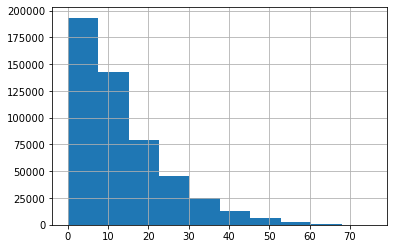

In [132]:
origins_snapped.NN_dist.apply(lambda x: x/1000).hist()

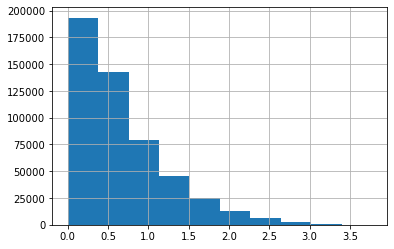

In [133]:
origins_snapped.NN_dist_hours.hist()

In [134]:
origins_join = origins_snapped.join(od_df, on='NN')

In [135]:
origins_join.head()

,grid_code,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours,new_obj_6434,new_obj_6039,37299,...,new_obj_6354,new_obj_6354,new_obj_6121,new_obj_6121,new_obj_6421,new_obj_6421,new_obj_3379,new_obj_3379,new_obj_7079_2595_12225,new_obj_7079_2595_12225
pointid,,,,,,,,,,,,,,,,,,,,,
1,0.023788,POINT (-60.00875 -19.29542),6668_533_2721,72124.911609,1,12982.484090,3.606246,89948.231102,70688.115131,92545.902376,...,91436.864744,91436.864744,98827.499603,98827.499603,89740.102284,89740.102284,110123.601133,110123.601133,45839.94,45839.94
2,0.027599,POINT (-60.00042 -19.29542),6668_533_2721,72785.491551,2,13101.388479,3.639275,89948.231102,70688.115131,92545.902376,...,91436.864744,91436.864744,98827.499603,98827.499603,89740.102284,89740.102284,110123.601133,110123.601133,45839.94,45839.94
3,0.023359,POINT (-59.99208 -19.29542),6668_533_2721,73450.560639,3,13221.100915,3.672528,89948.231102,70688.115131,92545.902376,...,91436.864744,91436.864744,98827.499603,98827.499603,89740.102284,89740.102284,110123.601133,110123.601133,45839.94,45839.94
4,0.017465,POINT (-59.98375 -19.29542),6668_533_2721,74119.997833,4,13341.599610,3.706000,89948.231102,70688.115131,92545.902376,...,91436.864744,91436.864744,98827.499603,98827.499603,89740.102284,89740.102284,110123.601133,110123.601133,45839.94,45839.94
5,0.020155,POINT (-59.97542 -19.29542),6668_533_2721,74793.685643,5,13462.863416,3.739684,89948.231102,70688.115131,92545.902376,...,91436.864744,91436.864744,98827.499603,98827.499603,89740.102284,89740.102284,110123.601133,110123.601133,45839.94,45839.94


In [140]:
all(origins_join.columns[7:] == dest_snapped.NN)

True

In [141]:
origins_join_rename = origins_join.copy()

In [142]:
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [143]:
origins_join_rename.head()

origin                                                            \
        grid_code                     geometry             NN       NN_dist   
pointid                                                                       
1        0.023788  POINT (-60.00875 -19.29542)  6668_533_2721  72124.911609   
2        0.027599  POINT (-60.00042 -19.29542)  6668_533_2721  72785.491551   
3        0.023359  POINT (-59.99208 -19.29542)  6668_533_2721  73450.560639   
4        0.017465  POINT (-59.98375 -19.29542)  6668_533_2721  74119.997833   
5        0.020155  POINT (-59.97542 -19.29542)  6668_533_2721  74793.685643   

                                                       city                \
        pointid NN_dist_seconds NN_dist_hours             0             1   
pointid                                                                     
1             1    12982.484090      3.606246  89948.231102  70688.115131   
2             2    13101.388479      3.639275  89948.231102  70688.115131   
3             3    13221.100915      3.672528  89948.231102  70688.115131   
4             4    13341.599610      3.706000  89948.231102  70688.115131   
5             5    13462.863416      3.739684  89948.231102  70688.115131   

                       ...        border                              \
                    2  ...            79            80            81   
pointid                ...                                             
1        92545.902376  ...  91436.864744  91436.864744  98827.499603   
2        92545.902376  ...  91436.864744  91436.864744  98827.499603   
3        92545.902376  ...  91436.864744  91436.864744  98827.499603   
4        92545.902376  ...  91436.864744  91436.864744  98827.499603   
5        92545.902376  ...  91436.864744  91436.864744  98827.499603   

                                                                  \
                   82            83            84             85   
pointid                                                            
1        98827.499603  89740.102284  89740.102284  110123.601133   
2        98827.499603  89740.102284  89740.102284  110123.601133   
3        98827.499603  89740.102284  89740.102284  110123.601133   
4        98827.499603  89740.102284  89740.102284  110123.601133   
5        98827.499603  89740.102284  89740.102284  110123.601133   

                                            
                    86        87        88  
pointid                                     
1        110123.601133  45839.94  45839.94  
2        110123.601133  45839.94  45839.94  
3        110123.601133  45839.94  45839.94  
4        110123.601133  45839.94  45839.94  
5        110123.601133  45839.94  45839.94  

[5 rows x 96 columns]

Add snapping time to each column (speed of 20 km/h)

In [144]:
# origins_join2 = origins_join_rename.copy()
origins_join2 = origins_join_rename.apply(lambda x: x + origins_join_rename.origin.NN_dist_seconds if x.name[1] in dest_snapped.index else x)

In [145]:
origins_join2.head()

origin                                                            \
        grid_code                     geometry             NN       NN_dist   
pointid                                                                       
1        0.023788  POINT (-60.00875 -19.29542)  6668_533_2721  72124.911609   
2        0.027599  POINT (-60.00042 -19.29542)  6668_533_2721  72785.491551   
3        0.023359  POINT (-59.99208 -19.29542)  6668_533_2721  73450.560639   
4        0.017465  POINT (-59.98375 -19.29542)  6668_533_2721  74119.997833   
5        0.020155  POINT (-59.97542 -19.29542)  6668_533_2721  74793.685643   

                                                        city                \
        pointid NN_dist_seconds NN_dist_hours              0             1   
pointid                                                                      
1             1    12982.484090      3.606246  102930.715191  83670.599221   
2             2    13101.388479      3.639275  103049.619581  83789.503610   
3             3    13221.100915      3.672528  103169.332017  83909.216046   
4             4    13341.599610      3.706000  103289.830712  84029.714741   
5             5    13462.863416      3.739684  103411.094518  84150.978547   

                        ...         border                                \
                     2  ...             79             80             81   
pointid                 ...                                                
1        105528.386466  ...  104419.348833  104419.348833  111809.983693   
2        105647.290856  ...  104538.253223  104538.253223  111928.888082   
3        105767.003292  ...  104657.965659  104657.965659  112048.600518   
4        105887.501986  ...  104778.464354  104778.464354  112169.099213   
5        106008.765792  ...  104899.728160  104899.728160  112290.363019   

                                                                     \
                    82             83             84             85   
pointid                                                               
1        111809.983693  102722.586374  102722.586374  123106.085222   
2        111928.888082  102841.490763  102841.490763  123224.989612   
3        112048.600518  102961.203199  102961.203199  123344.702048   
4        112169.099213  103081.701894  103081.701894  123465.200743   
5        112290.363019  103202.965700  103202.965700  123586.464548   

                                                    
                    86            87            88  
pointid                                             
1        123106.085222  58822.424090  58822.424090  
2        123224.989612  58941.328479  58941.328479  
3        123344.702048  59061.040915  59061.040915  
4        123465.200743  59181.539610  59181.539610  
5        123586.464548  59302.803416  59302.803416  

[5 rows x 96 columns]

In [147]:
origins_join2.to_csv(os.path.join(output_path, 'OD_06_10.csv'))

In [148]:
od_cities = np.array(origins_join2['city'])

### Calculate gravity

In [150]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.Pop[origins_join2['city'].columns])

CPU times: user 10min 6s, sys: 3.88 s, total: 10min 10s
Wall time: 10min 6s


In [155]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

#### Reload

In [3]:
# def load_csv(csv_path, geometry = 'geometry', crs = 'epsg:4326'):
#     df = pd.read_csv(csv_path)
#     df[geometry] = df[geometry].apply(loads)
#     gdf = gpd.GeoDataFrame(df, crs = crs)
#     return(gdf)

#### Convert to raster and save results

In [156]:
sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

In [157]:
wp_1km

'/home/wb514197/data/INFRA_SAP/PRY/WP_2020_1km.tif'

In [158]:
raster_path = wp_1km

'/home/wb514197/data/INFRA_SAP/PRY/out'

In [162]:
out_folder

'/home/wb514197/data/INFRA_SAP/PRY'

In [163]:
output_path = os.path.join(out_folder, "out", "access")
if not os.path.exists(output_path):
    os.mkdir(output_path)

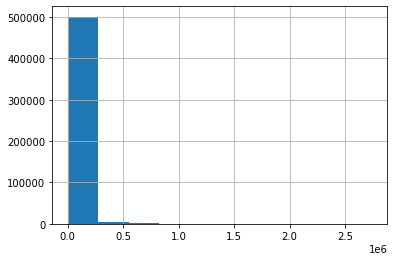

In [159]:
access_cities_results.d_5.hist()

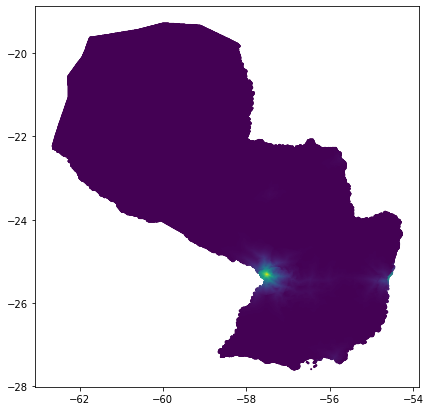

In [160]:
access_cities_results.plot(column='d_5', figsize=(7,7), markersize=1)

In [164]:
for d in range(5,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=raster_path, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 5
writing 6
writing 7
writing 8
writing 9


### Make rasters of min travel time to each dest

In [165]:
sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

In [167]:
output_path = os.path.join(out_folder, "out", "travel_time")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [168]:
origins_join2['city']

,0,1,2,3,4,5,6,7
pointid,,,,,,,,
1,102930.715191,83670.599221,105528.386466,109560.878986,95091.416836,122087.622137,106852.855113,127613.074331
2,103049.619581,83789.503610,105647.290856,109679.783375,95210.321225,122206.526527,106971.759503,127731.978721
3,103169.332017,83909.216046,105767.003292,109799.495811,95330.033661,122326.238963,107091.471939,127851.691157
4,103289.830712,84029.714741,105887.501986,109919.994506,95450.532356,122446.737658,107211.970634,127972.189851
5,103411.094518,84150.978547,106008.765792,110041.258312,95571.796162,122568.001464,107333.234440,128093.453657
...,...,...,...,...,...,...,...,...
508180,70887.106858,69160.164297,35663.891531,39462.180937,32746.836304,35124.992247,31929.853994,11019.829944
508181,70792.344812,69065.402250,35569.129485,39367.418890,32652.074258,35030.230201,31835.091948,10925.067898
508182,70712.693016,68985.750454,35489.477689,39287.767094,32572.422461,34950.578404,31755.440152,10845.416101


In [169]:
city_min = pd.DataFrame(origins_join2['city'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_city"])
ports_min = pd.DataFrame(origins_join2['port'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_port"])
airports_min = pd.DataFrame(origins_join2['airport'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_airport"])
borders_min = pd.DataFrame(origins_join2['border'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_border"])

In [190]:
capital_tt = origins_join2['city'].loc[:,[4]].apply(lambda x: (x/3600)).rename(columns={4:'tt_capital'})

In [191]:
origins_tt = origins_snapped.join([city_min, ports_min, airports_min, borders_min, capital_tt])

In [187]:
output_path

'/home/wb514197/data/INFRA_SAP/PRY/out/travel_time'

In [189]:
origins_tt

,grid_code,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours,tt_city,tt_port,tt_airport,tt_border,4
pointid,,,,,,,,,,,,
1,0.023788,POINT (-60.00875 -19.29542),6668_533_2721,72124.911609,1,12982.484090,3.606246,23.241833,13.045611,26.040317,16.339562,26.414282
2,0.027599,POINT (-60.00042 -19.29542),6668_533_2721,72785.491551,2,13101.388479,3.639275,23.274862,13.078640,26.073346,16.372591,26.447311
3,0.023359,POINT (-59.99208 -19.29542),6668_533_2721,73450.560639,3,13221.100915,3.672528,23.308116,13.111894,26.106600,16.405845,26.480565
4,0.017465,POINT (-59.98375 -19.29542),6668_533_2721,74119.997833,4,13341.599610,3.706000,23.341587,13.145366,26.140072,16.439317,26.514037
5,0.020155,POINT (-59.97542 -19.29542),6668_533_2721,74793.685643,5,13462.863416,3.739684,23.375272,13.179050,26.173756,16.473001,26.547721
...,...,...,...,...,...,...,...,...,...,...,...,...
508180,4.227770,POINT (-56.85875 -27.59542),new_obj_530_1988_9746,5763.358594,508180,1037.404547,0.288168,3.061064,5.184133,9.397887,3.028882,9.096343
508181,3.730930,POINT (-56.85042 -27.59542),new_obj_530_1988_9746,5236.902780,508181,942.642500,0.261845,3.034741,5.157810,9.371565,3.002559,9.070021
508182,3.511680,POINT (-56.84208 -27.59542),new_obj_530_1988_9746,4794.392801,508182,862.990704,0.239720,3.012616,5.135685,9.349439,2.980433,9.047895


In [192]:
aggregator.rasterize_gdf(origins_tt, 'tt_city', raster_path, os.path.join(output_path,f"cities_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_port', raster_path, os.path.join(output_path,f"port_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_airport', raster_path, os.path.join(output_path,f"airport_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_border', raster_path, os.path.join(output_path,f"borders_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_capital', raster_path, os.path.join(output_path,f"capital_tt.tif"))